In [5]:
from mlforecast import MLForecast

In [6]:
from mlforecast.auto import AutoMLForecast, AutoLightGBM, AutoXGBoost, AutoRidge

c:\Users\wesst\toolkit\tool-kit\.venv\Lib\site-packages\utilsforecast\losses.py:420: SyntaxWarning: invalid escape sequence '\m'
  """Multi-Quantile loss (MQL)


In [7]:
from statsforecast.utils import AirPassengersDF
df = AirPassengersDF
df

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0
...,...,...,...
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0
142,1.0,1960-11-30,390.0


In [8]:
auto_mlf = AutoMLForecast(
    freq='ME',  # frequency of your time series (e.g., 'D' for daily, 'W' for weekly)
    season_length=12,  # length of seasonality in your data
    models={
        'lgb': AutoLightGBM(),
        'xgb': AutoXGBoost(),
        'ridge': AutoRidge()
    },
    num_threads=4  # number of threads to use for parallel processing
)

In [17]:
auto_mlf.fit(n_windows=3, df=df, h = 5, num_samples=20)


[I 2024-08-25 20:40:25,506] A new study created in memory with name: no-name-0eb4b82a-b06e-4509-94a0-adab4cff464d
[I 2024-08-25 20:40:25,783] Trial 0 finished with value: 0.056893984287298915 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 0 with value: 0.056893984287298915.
[I 2024-08-25 20:40:25,876] Trial 1 finished with value: 0.07053752230301659 and parameters: {'n_estimators': 422, 'lambda_l1': 1.1600316346542318e-07, 'lambda_l2': 0.005744988873954126, 'num_leaves': 5, 'feature_fraction': 0.972334458524792, 'bagging_fraction': 0.7609241608750359, 'objective': 'l1', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 0 with value: 0.0568939842872

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'xgb': AutoModel(model=XGBRegressor), 'ridge': AutoModel(model=Ridge)})

In [18]:
auto_mlf.predict(h = 5)

,unique_id,ds,lgb,xgb,ridge
0,1.0,1961-01-31,443.309653,444.287494,456.847798
1,1.0,1961-02-28,413.654213,416.056641,428.689291
2,1.0,1961-03-31,442.493393,445.316753,459.456727
3,1.0,1961-04-30,483.866891,489.050229,503.317255
4,1.0,1961-05-31,494.846210,499.993219,526.709148


In [19]:
auto_mlf.models_

{'lgb': MLForecast(models=[lgb], freq=ME, lag_features=['exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag12_window_size12_min_samples1'], date_features=['month', 'year'], num_threads=4),
 'xgb': MLForecast(models=[xgb], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'exponentially_weighted_mean_lag1_alpha0.9'], date_features=[], num_threads=4),
 'ridge': MLForecast(models=[ridge], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag12_window_size12_min_samples1', 'rolling_mean_lag5_window_size12_min_samples1'], date_features=['month', 'year'], num_threads=4)}

In [20]:
from utilsforecast.plotting import plot_series

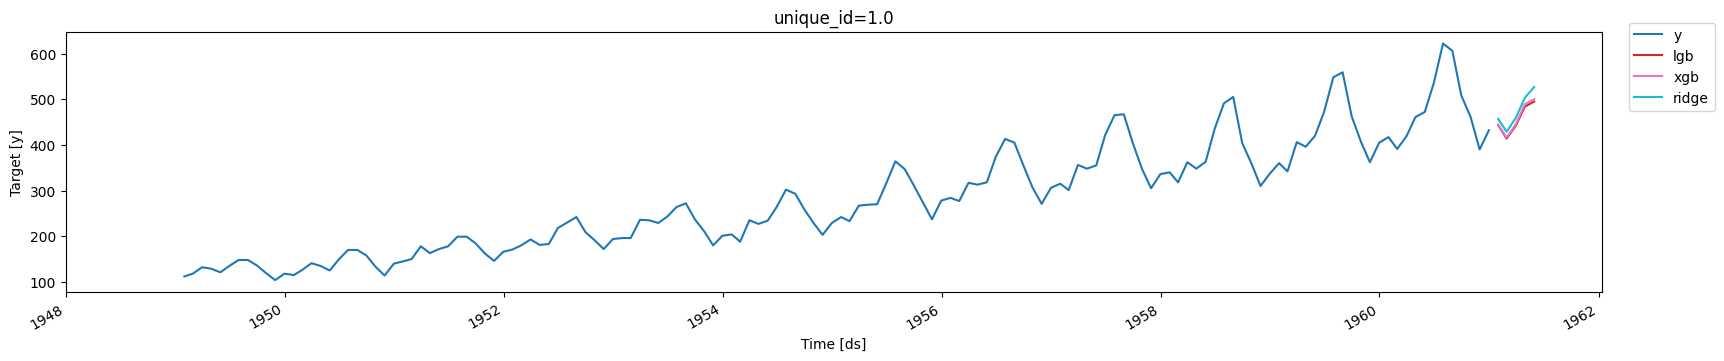

In [21]:
plot_series(df, auto_mlf.predict(h = 5))

In [22]:
from mlforecast.auto import AutoModel, AutoMLForecast
import optuna

In [23]:
from sklearn.linear_model import (
    LinearRegression, 
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
    QuantileRegressor,
    Lasso, 
    LassoCV,
    Ridge, 
    ElasticNet, 
    ElasticNetCV,

)

In [27]:
def lasso_space(trial):
    return {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

def ridge_space(trial):
    return {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 100),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'max_iter': trial.suggest_int('max_iter', 100, 10000),
        'tol': trial.suggest_loguniform('tol', 1e-6, 1e-2),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']),
        'positive': trial.suggest_categorical('positive', [True, False])
    }

In [25]:


auto_models = {
    'ridge': AutoModel(Ridge(), ridge_space),
}

In [28]:
auto_mlf = AutoMLForecast(
    freq='ME',  # frequency of your time series (e.g., 'D' for daily, 'W' for weekly)
    season_length=12,  # length of seasonality in your data
    models=auto_models,
    num_threads=4  # number of threads to use for parallel processing
)

In [32]:
auto_mlf.fit(n_windows=3, df=df, h = 12, num_samples=20)

[I 2024-08-25 20:47:53,896] A new study created in memory with name: no-name-228337a3-30f0-4f59-992d-2fe08e6ac823
C:\Users\wesst\AppData\Local\Temp\ipykernel_26224\2876584177.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-5, 1),
[I 2024-08-25 20:47:54,088] Trial 0 finished with value: 0.03306883682233575 and parameters: {'alpha': 0.005547119471592123, 'max_iter': 744, 'target_transforms_idx': 6, 'lags_idx': 1, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 0 with value: 0.03306883682233575.
C:\Users\wesst\AppData\Local\Temp\ipykernel_26224\2876584177.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

AutoMLForecast(models={'ridge': AutoModel(model=Ridge)})

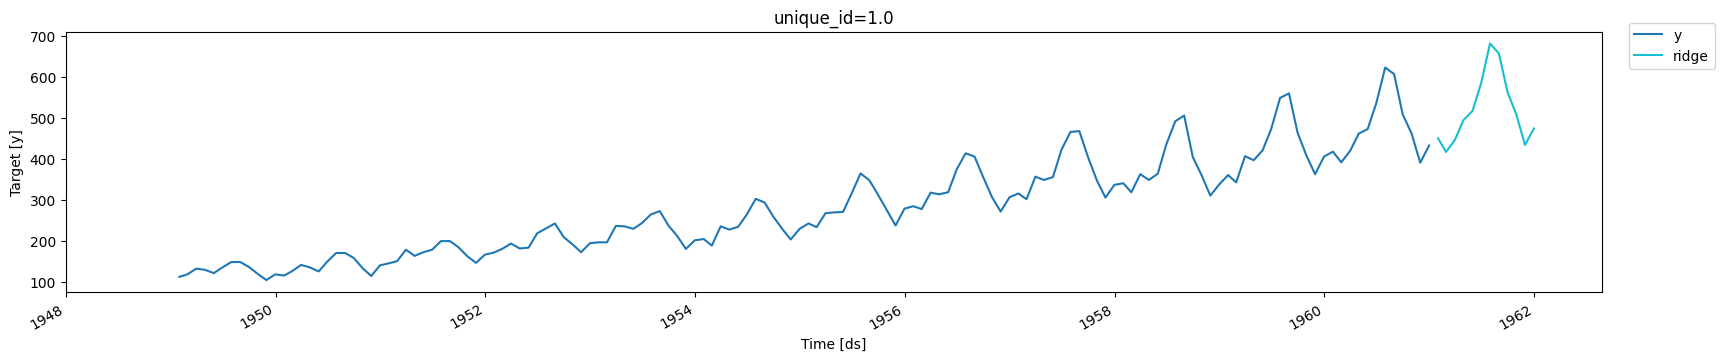

In [33]:
plot_series(df, auto_mlf.predict(h = 12))